In [1]:
!pip install pandas

In [2]:
import pandas as pd

# Adjust filename based on actual extracted file
df = pd.read_csv('./data/complaints.csv')

# Preview



/tmp/ipython-input-2-3765508250.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/complaints.csv')


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


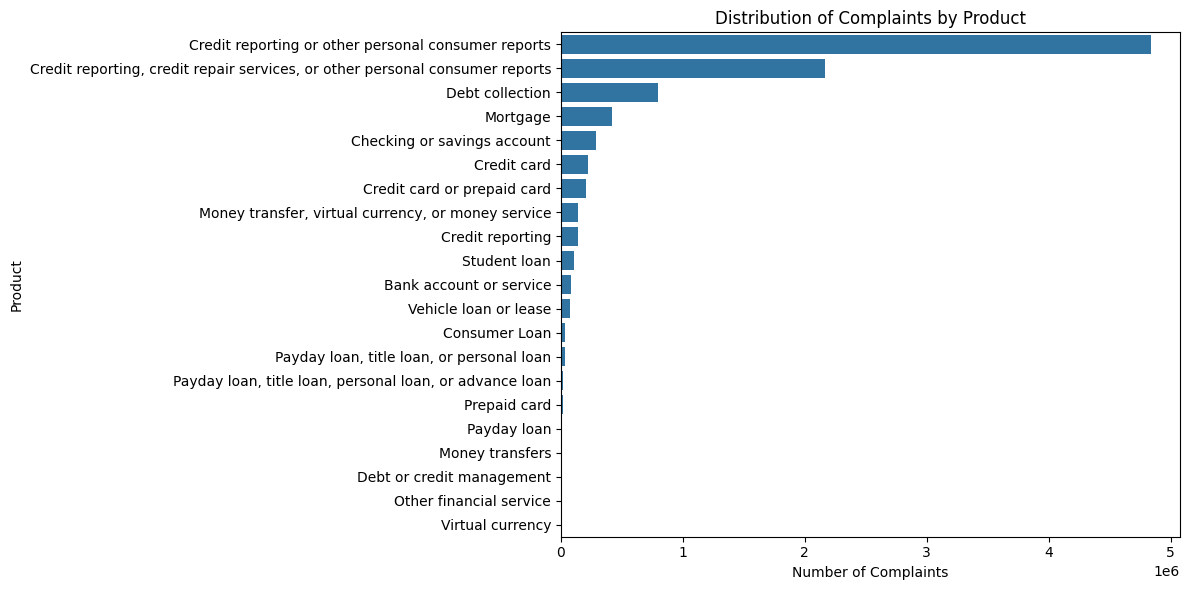

In [7]:

# 1. Distribution of complaints across products
product_counts = df['Product'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=product_counts.values, y=product_counts.index)
plt.title('Distribution of Complaints by Product')
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

Narrative Length Statistics:
 count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_length, dtype: float64


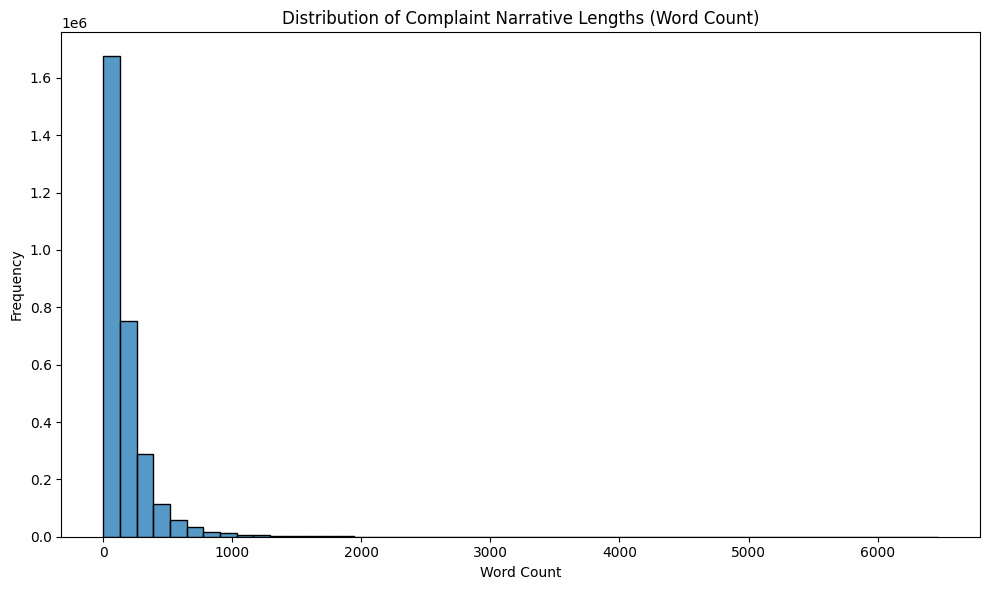

In [8]:
# 2. Analyze narrative length
df['narrative_length'] = df['Consumer complaint narrative'].dropna().apply(lambda x: len(str(x).split()))
narrative_stats = df['narrative_length'].describe()
print("Narrative Length Statistics:\n", narrative_stats)

plt.figure(figsize=(10, 6))
sns.histplot(df['narrative_length'].dropna(), bins=50)
plt.title('Distribution of Complaint Narrative Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Narrative Presence:
 {'With Narrative': np.int64(2980756), 'Without Narrative': np.int64(6629041)}


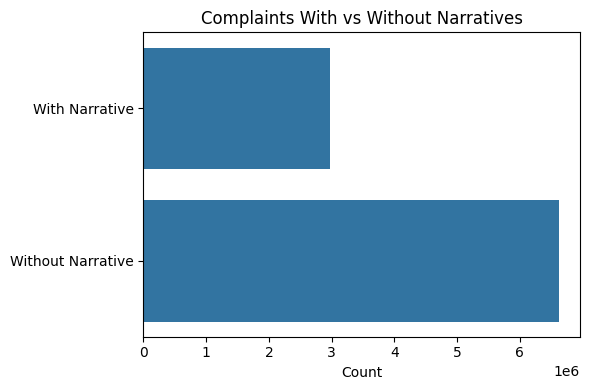

In [9]:
# 3. Complaints with and without narratives
narrative_counts = {
    'With Narrative': df['Consumer complaint narrative'].notna().sum(),
    'Without Narrative': df['Consumer complaint narrative'].isna().sum()
}
print("Narrative Presence:\n", narrative_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(narrative_counts.values()), y=list(narrative_counts.keys()))
plt.title('Complaints With vs Without Narratives')
plt.xlabel('Count')
plt.tight_layout()
plt.show()


In [10]:

# --- Data Preprocessing ---

# Define product and sub-product mappings
product_mapping = {
    # Credit Card
    'Credit card': 'Credit Card',
    'Credit card or prepaid card': 'Credit Card',
    # Personal Loan
    'Consumer Loan': 'Personal Loan',
    'Payday loan, title loan, or personal loan': 'Personal Loan',
    # Buy Now, Pay Later (BNPL)
    'Payday loan, title loan, personal loan, or advance loan': 'Buy Now, Pay Later (BNPL)',
    'Payday loan': 'Buy Now, Pay Later (BNPL)',
    # Savings Account
    'Checking or savings account': 'Savings Account',
    'Bank account or service': 'Savings Account',
    # Money Transfers
    'Money transfer, virtual currency, or money service': 'Money Transfers',
    'Money transfers': 'Money Transfers'
}

subproduct_mapping = {
    # Credit Card
    'General-purpose credit card or charge card': 'Credit Card',
    'Store credit card': 'Credit Card',
    'Credit card debt': 'Credit Card',
    'General purpose card': 'Credit Card',
    # Personal Loan
    'Personal line of credit': 'Personal Loan',
    'Installment loan': 'Personal Loan',  # Will refine with narrative
    # Buy Now, Pay Later (BNPL)
    'Payday loan': 'Buy Now, Pay Later (BNPL)',
    'Earned wage access': 'Buy Now, Pay Later (BNPL)',
    # Savings Account
    'Savings account': 'Savings Account',
    'CD (Certificate of Deposit)': 'Savings Account',
    '(CD) Certificate of deposit': 'Savings Account',
    # Money Transfers
    'Mobile or digital wallet': 'Money Transfers',
    'Domestic (US) money transfer': 'Money Transfers',
    'International money transfer': 'Money Transfers',
    'Money order': 'Money Transfers',
    'Money order, traveler\'s check or cashier\'s check': 'Money Transfers',
    'Traveler\'s check or cashier\'s check': 'Money Transfers',
    'Check cashing service': 'Money Transfers'
}


In [11]:
# Filter for relevant products and sub-products
relevant_products = list(product_mapping.keys())
relevant_subproducts = list(subproduct_mapping.keys())
df_filtered = df[
    (df['Product'].isin(relevant_products)) |
    (df['Sub-product'].isin(relevant_subproducts))
].copy()

# Apply product and sub-product mappings
df_filtered['Product'] = df_filtered['Product'].map(product_mapping)
df_filtered['Product'] = df_filtered['Sub-product'].map(subproduct_mapping).combine_first(df_filtered['Product'])

In [13]:
# Remove records with empty narratives or unclassified products
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].notna() & df_filtered['Product'].notna()]

In [16]:
# Clean text narratives
import re
def clean_narrative(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
    boilerplate = [
        r'i am writing to file a complaint',
        r'please investigate',
        r'this is regarding a complaint'
    ]
    for phrase in boilerplate:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    text = ' '.join(text.split())
    return text

df_filtered['Consumer complaint narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)


In [17]:

OUTPUT_PATH = '/content/drive/MyDrive/data/filtered_complaints.csv'

df_filtered.to_csv(OUTPUT_PATH, index=False)
print(f"Cleaned dataset saved to {OUTPUT_PATH}")

# Verify unique products and distribution
print("\nUnique Products in Filtered Dataset:")
print(df_filtered['Product'].unique())
print("\nProduct Distribution:")
print(df_filtered['Product'].value_counts())



Cleaned dataset saved to /content/drive/MyDrive/data/filtered_complaints.csv

Unique Products in Filtered Dataset:
['Credit Card' 'Savings Account' 'Buy Now, Pay Later (BNPL)'
 'Personal Loan' 'Money Transfers']

Product Distribution:
Product
Credit Card                  254746
Savings Account              155204
Money Transfers               98736
Personal Loan                 28757
Buy Now, Pay Later (BNPL)     10643
Name: count, dtype: int64


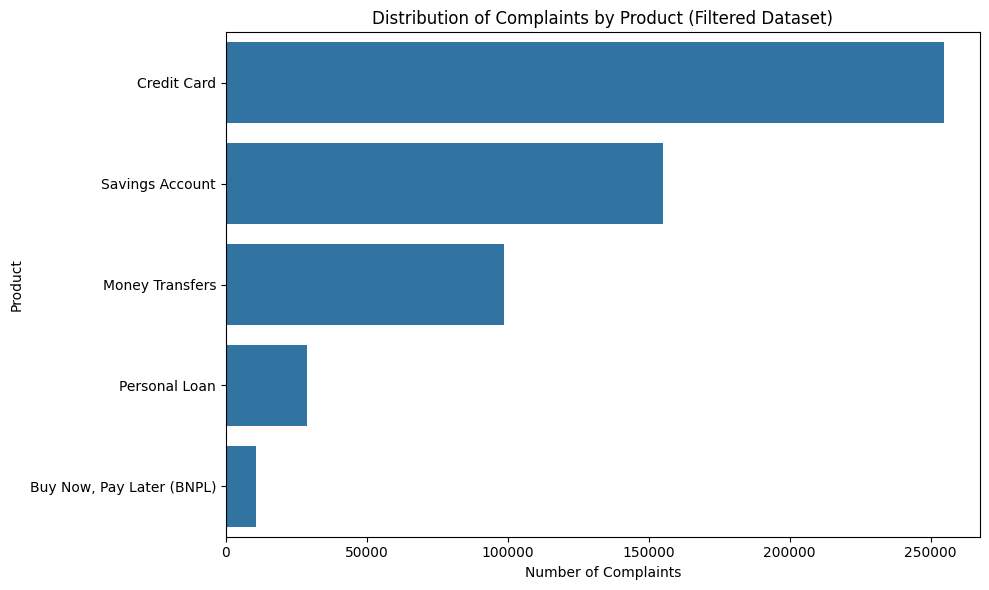

In [18]:
# Visualize filtered product distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=df_filtered['Product'].value_counts().values, y=df_filtered['Product'].value_counts().index)
plt.title('Distribution of Complaints by Product (Filtered Dataset)')
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.tight_layout()
plt.show()